In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import json
import pandas as pd

dir_path = 'autogptq_eval_result/deepseek-moe-16b-base'  # Directory containing the files

def extract_bits(filename):
    """Extract the bits part from the filename."""
    try:
        return filename.split("_w_bit_")[1].split("_pile")[0]
    except IndexError:
        return None

all_data = {}

for filename in os.listdir(dir_path):
    if filename.startswith("eval_result_deepseek-moe-16b-base-gptq_w_bit_") and filename.endswith("_pile") and 'layer_' in filename:
        bits = extract_bits(filename)
        if bits:  # Ensure bits part was successfully extracted
            file_path = os.path.join(dir_path, filename)
            try:
                with open(file_path, 'r') as file:
                    content = json.load(file)
                    all_data[bits] = content
            except json.JSONDecodeError:
                # If JSON is invalid, skip this file
                continue

df = pd.DataFrame.from_dict(all_data, orient='index')

df.index.name = 'Bits'

csv_path = os.path.join(dir_path, 'evaluation_results_all_layer.csv')
df.to_csv(csv_path)

print(f"CSV file has been saved to {csv_path}")


CSV file has been saved to autogptq_eval_result/deepseek-moe-16b-base/evaluation_results_all_layer.csv


In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from argparse import ArgumentParser
import csv
import torch
from auto_gptq import moe_quantize_config_layer

class parse_args:
    def __init__(self, bits):
        self.bits = bits
model = AutoModelForCausalLM.from_pretrained('deepseek-ai/deepseek-moe-16b-base', torch_dtype=torch.float16, trust_remote_code=True)

log_data = []

def extract_bits(filename):
    """Extract the bits part from the filename."""
    try:
        return filename.split("_w_bit_")[1].split("_pile")[0]
    except IndexError:
        return None

eval_bits = []

for filename in os.listdir('autogptq_eval_result/deepseek-moe-16b-base'):
    if filename.startswith("eval_result_deepseek-moe-16b-base-gptq_w_bit_") and filename.endswith("_pile") and 'layer_' in filename:
        bits = extract_bits(filename)
        eval_bits.append(bits)

print(f"len(eval_bits): {len(eval_bits)}")


for bits in eval_bits:
    args = parse_args(bits)
    
    deeepseek_bit = moe_quantize_config_layer(args)
    
    total_bits_moe = 0
    total_params_moe = 0
    total_bits_self_attn = 0
    total_params_self_attn = 0
    total_bits = 0
    total_params = 0
    
    for name, module in model.named_modules():
        if hasattr(module, 'weight'):
            weight = module.weight.data
            num_params = weight.numel()  # Total number of parameters in the module
            
            if name in deeepseek_bit:
                bit = deeepseek_bit[name]
                total_bits += num_params * bit  # Accumulate total bits for all specified modules
                total_params += num_params
                
            if ('experts' in name or 'shared_experts' in name) and name in deeepseek_bit:
                bit = deeepseek_bit[name]
                total_bits_moe += num_params * bit
                total_params_moe += num_params
                
                # print(f'name {name} | bit {bit}')
                # print(f'total_bits_moe {total_bits_moe} | num_params {num_params} | bit {bit}')
            elif 'self_attn' in name and name in deeepseek_bit:
                bit = deeepseek_bit[name]
                total_bits_self_attn += num_params * bit
                total_params_self_attn += num_params
        
    
    average_bit_moe = total_bits_moe / total_params_moe if total_params_moe > 0 else 0
    average_bit_self_attn = total_bits_self_attn / total_params_self_attn if total_params_self_attn > 0 else 0
    average_bit = total_bits / total_params if total_params > 0 else 0
    print(f"Bits: {bits}")
    print(f"MoE Average Bit: {average_bit_moe}")
    print(f"Self-Attention Average Bit: {average_bit_self_attn}")
    print(f"Average Bit: {average_bit}")
    print('=========================')
    
    data = {
        "Bits": bits,
        "MoE Average Bit": average_bit_moe,
        "Self-Attention Average Bit": average_bit_self_attn,
        "Average Bit": average_bit
    }
    
    # Add the data to the list
    log_data.append(data)

fieldnames = ["Bits", "MoE Average Bit", "Self-Attention Average Bit", "Average Bit"]

# Open a CSV file to write the data
save_path = 'autogptq_eval_result/deepseek-moe-16b-base/deepseek_bits_data_layer.csv'
with open(save_path, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()
    
    # Write the log data
    writer.writerows(log_data)

print(f"Log data has been saved to {save_path}.")


CUDA extension not installed.
CUDA extension not installed.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

len(eval_bits): 12
Bits: moe.shared_8.top25_4.other_2+other_block.4+endlayer_10
MoE Average Bit: 2.6588103254769924
Self-Attention Average Bit: 4.0
Average Bit: 2.7039578009843153
Bits: moe.shared_8.top25_4.other_2+other_block.4+endlayer_20
MoE Average Bit: 2.378226711560045
Self-Attention Average Bit: 4.0
Average Bit: 2.432819265625385
Bits: moe.shared_8.top25_4.other_2+other_block.4+startlayer_27
MoE Average Bit: 2.1818181818181817
Self-Attention Average Bit: 4.0
Average Bit: 2.2430222908741344
Bits: moe.shared_8.top25_4.other_2+other_block.4+endlayer_25
MoE Average Bit: 2.237934904601571
Self-Attention Average Bit: 4.0
Average Bit: 2.29724999794592
Bits: moe.shared_8.top25_4.other_2+other_block.4+startlayer_10
MoE Average Bit: 2.6588103254769924
Self-Attention Average Bit: 4.0
Average Bit: 2.7039578009843153
Bits: moe.shared_8.top25_4.other_2+other_block.4+endlayer_5
MoE Average Bit: 2.7991021324354657
Self-Attention Average Bit: 4.0
Average Bit: 2.83952706866378
Bits: moe.shared_8.

61

Log data has been saved to autogptq_eval_result/deepseek-moe-16b-base/deepseek_bits_data_layer.csv.


In [4]:
import pandas as pd

df1 = pd.read_csv('/home/LeiFeng/xiaolong/moe_quantize/autogptq_eval_result/deepseek-moe-16b-base/deepseek_bits_data_layer.csv')
df2 = pd.read_csv('/home/LeiFeng/xiaolong/moe_quantize/autogptq_eval_result/deepseek-moe-16b-base/evaluation_results_all_layer.csv')

merged_df = pd.merge(df1, df2, on='Bits', how='outer')

merged_df.to_csv('/home/LeiFeng/xiaolong/moe_quantize/autogptq_eval_result/deepseek-moe-16b-base/evaluation_results_final_layer.csv', index=False)


<BarContainer object of 30 artists>

<BarContainer object of 30 artists>

<BarContainer object of 30 artists>

<BarContainer object of 30 artists>

<BarContainer object of 30 artists>

<BarContainer object of 30 artists>

<BarContainer object of 30 artists>

<BarContainer object of 30 artists>

Text(0.5, 1.0, 'Output Proj. Weight Distribution')

Text(0.5, 1.0, 'Down Proj. Weight Distribution')

Text(0.5, 0, 'Layer')

Text(0, 0.5, 'Absolute Weight Value')

Text(0.5, 0, 'Layer')

Text(0, 0.5, 'Absolute Weight Value')

Text(0.5, 0.98, 'Figure 3: The distributions of the (normalized) absolute weight values, for the output layers in MHA and the down layers in FFN across different layers in LLaMA-7B. Note that the distributions exhibit outlier patterns across all layers, with 99% of the values clustered within ~10% of the entire range.')

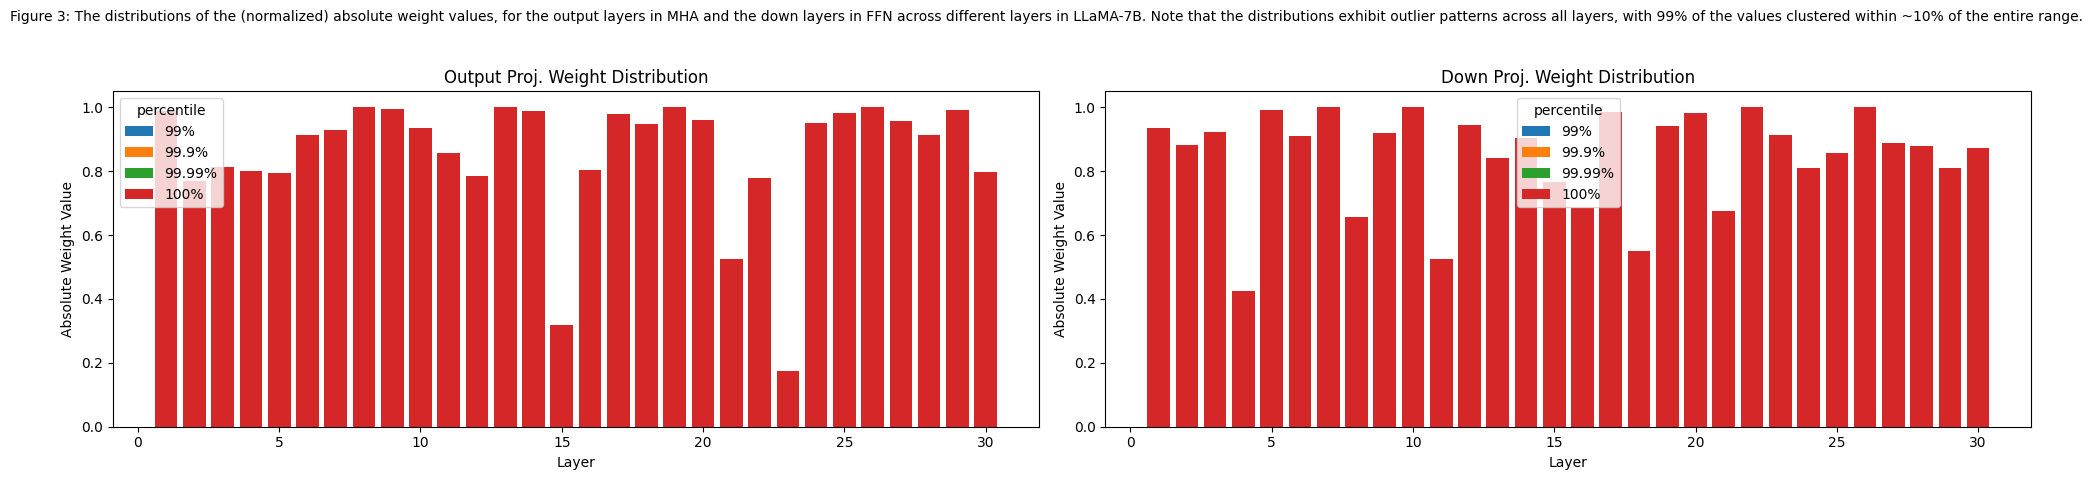

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Example data representing the weight distributions for each layer
# This would normally be your actual data from the model's layers
output_proj_weights = np.random.rand(30, 4) # For output projection layers
down_proj_weights = np.random.rand(30, 4)  # For down projection layers

# Normalize the data (if needed)
output_proj_weights = output_proj_weights / output_proj_weights.max(axis=0)
down_proj_weights = down_proj_weights / down_proj_weights.max(axis=0)

# Sort the weights to simulate percentiles
output_proj_weights.sort(axis=1)
down_proj_weights.sort(axis=1)

# The layers
layers = np.arange(1, 31)

# Create the bar charts
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for i, percentile in enumerate(['99%', '99.9%', '99.99%', '100%']):
    axs[0].bar(layers, output_proj_weights[:, i], label=percentile)
    axs[1].bar(layers, down_proj_weights[:, i], label=percentile)

# Set the title and labels
axs[0].set_title('Output Proj. Weight Distribution')
axs[1].set_title('Down Proj. Weight Distribution')
for ax in axs:
    ax.set_xlabel('Layer')
    ax.set_ylabel('Absolute Weight Value')

# Add legend
axs[0].legend(title='percentile')
axs[1].legend(title='percentile')

# Add the overall figure title
fig.suptitle('Figure 3: The distributions of the (normalized) absolute weight values, for the output layers in MHA and the down layers in FFN across different layers in LLaMA-7B. Note that the distributions exhibit outlier patterns across all layers, with 99% of the values clustered within ~10% of the entire range.', fontsize=10)

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rect to make space for the figure title
plt.show()


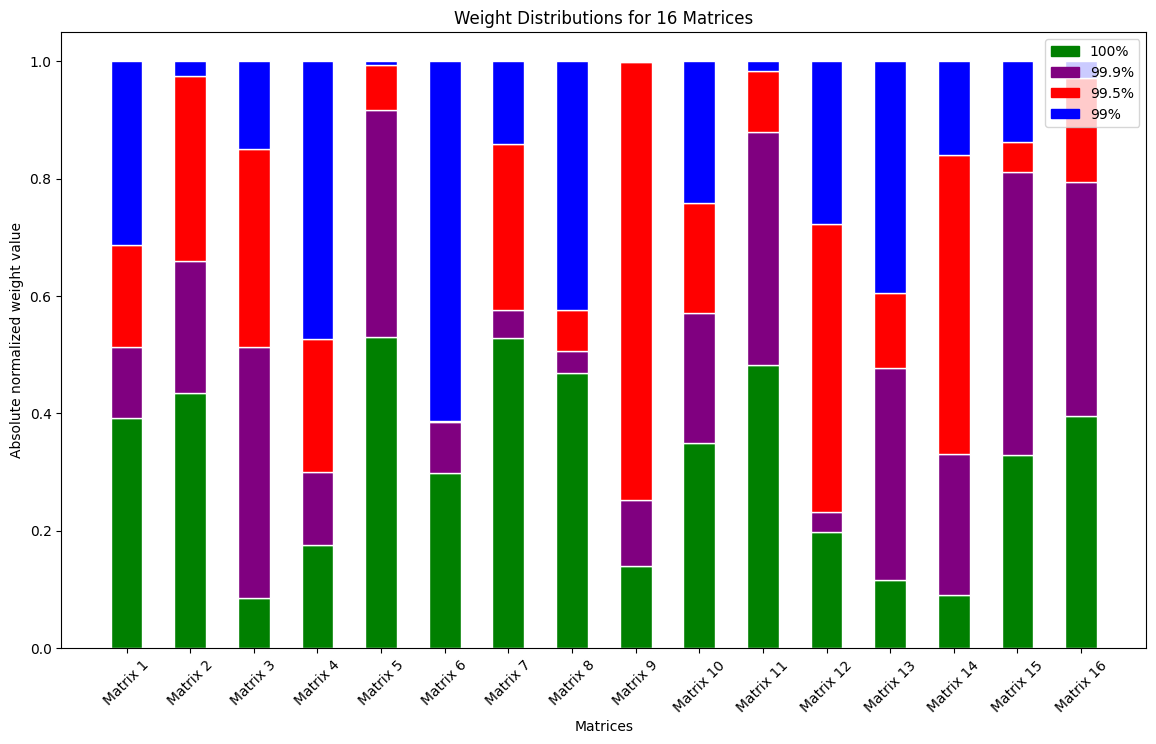

In [7]:
# Function to draw a bar chart with different colors representing the weight distribution for multiple matrices
def draw_multiple_bars_distribution(num_matrices, percentiles, colors, title, y_label):
    fig, ax = plt.subplots(figsize=(14, 8))

    # Width of a bar
    bar_width = 0.5

    # Positions of the left bar-boundaries
    bar_l = [i+1 for i in range(num_matrices)]

    # Create bars for each matrix
    for i in range(num_matrices):
        # Create a bar with different colors representing the distribution
        bottom = 0  # The starting point for the next segment of the bar
        for percentile, color in zip(percentiles[i], colors):
            ax.bar(bar_l[i], percentile, bottom=bottom, color=color, edgecolor='white', width=bar_width)
            bottom += percentile

    # Set the x-axis labels
    ax.set_xticks(bar_l)
    ax.set_xticklabels([f'{i+1}' for i in range(num_matrices)], rotation=45)

    # Set the labels and title
    plt.ylabel(y_label)
    plt.xlabel('Matrices')
    plt.title(title)

    # Create a legend
    patches = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
    labels = ['100%', '99.9%', '99.5%', '99%']
    plt.legend(patches, labels, loc='upper right')

    # Show the figure
    plt.show()

# Generate random distributions for 16 matrices
# The distributions are made up for demonstration purposes and assume they sum up to 1 for each matrix.
random_distributions = [np.random.dirichlet(np.ones(4)) for _ in range(16)]
colors = ['green', 'purple', 'red', 'blue']

# Draw the multiple bars distribution plot
draw_multiple_bars_distribution(16, random_distributions, colors, 'Weight Distributions for 16 Matrices', 'Absolute normalized weight value')
